Notebook to determine the noise level in AZKABAN during zooplankton experiment January 2022 in Ny-Ålesund

In [1]:
import csv
import os
from datetime import timedelta
import numpy as np
import pandas as pd
import scipy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
from datetime import datetime
import matplotlib.dates as mdates
import warnings
%matplotlib inline

In [2]:
sns.set_theme(style="whitegrid")
sns.color_palette("viridis", as_cmap=True)
title_font = {
    'fontname': 'DejaVu Sans', 'size': '15', 'color': 'black',
    'weight': 'medium'
}
axis_font = {'fontname': 'DejaVu Sans', 'size': '15', 'color': 'black'}

warnings.simplefilter("ignore")

mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['axes.labelsize'] = 16



# Read SED
Compare TS from SEDs with regular parameters to the noise level

In [9]:
def tsf_import(file_path):

    """
    This function imports wideband frequency response .csv files exported from
    Echoview and performs some basic housekeeping.
    
    PARAMETERS:
        file_path: Path to wideband frequency response .csv file from Echoview.
        
    RETURNS:
        df: Pandas dataframe.
    """
    
    def get_datetime(df):
        """
        Convert Echoview timestamps in imported .csv to datetime.
        """
        df['Ping_microseconds'] = df.Ping_milliseconds * 1000
        df['Ping_microseconds'] = [timedelta(microseconds = i) for i in df['Ping_microseconds']]
        df['Datetime'] = df['Ping_date_Ping_time'] + df['Ping_microseconds']
        df.drop(columns=['Ping_date_Ping_time',
                         'Ping_milliseconds',
                         'Ping_microseconds'],
               inplace=True)
        
        return df
    
    transposed_path = file_path[:-4] + '_transposed.csv'
    if os.path.isfile(transposed_path) == True:
        df = pd.read_csv(transposed_path,
                         index_col='Target_index',
                         skiprows=1,
                         skipfooter=2,
                         engine='python',
                         parse_dates=[['Ping_date', 'Ping_time']])
    else:
        df = pd.read_csv(file_path, low_memory=False).T
        file_path = transposed_path
        df.to_csv(path_or_buf=file_path)
        print('A transposed TS(f) file was created at: \n' + str(file_path))    
        df = pd.read_csv(file_path,
                         index_col='Target_index',
                         skiprows=1,
                         skipfooter=2,
                         engine='python',
                         parse_dates=[['Ping_date', 'Ping_time']])
    
    df = get_datetime(df)
    
    return df


In [10]:
SED80_df = tsf_import('C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/AZKABAN-light/ZoopMix_paper/Freqtest80.csv')

A transposed TS(f) file was created at: 
C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/AZKABAN-light/ZoopMix_paper/Freqtest80_transposed.csv


In [13]:
SED140_df = tsf_import('C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/AZKABAN-light/ZoopMix_paper/Freqtest140.csv')

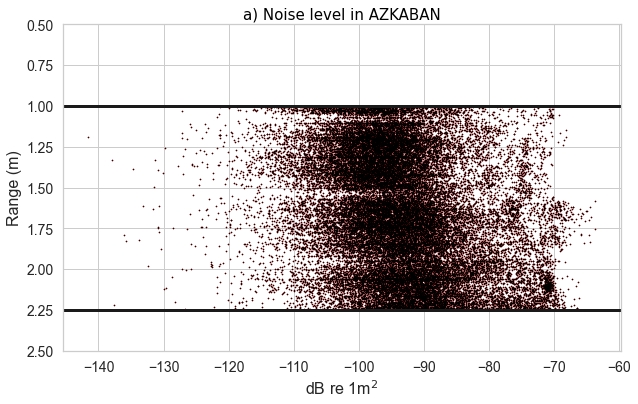

In [14]:
plt.figure(figsize=(10,6))
plt.plot(SED80_df['200.000'],SED80_df['Range'], '.', color='red',markersize=1)
plt.plot(SED140_df['200.000'],SED140_df['Range'], '.', color='black',markersize=1)
plt.axhline(y=1, c='k', linewidth=3)
plt.axhline(y=2.25, c='k', linewidth=3)
plt.ylim([0.5,2.5])
plt.xlabel('dB re 1m$^2$')
plt.ylabel('Range (m)')
#plt.legend(fontsize=15)
plt.title('a) Noise level in AZKABAN', title_font)
plt.gca().invert_yaxis()



In [21]:
SED140_df==SED80_df

,Ping_index,Range,Depth,185.000,185.500,186.000,186.500,187.000,187.500,188.000,...,251.000,251.500,252.000,252.500,253.000,253.500,254.000,254.500,255.000,Datetime
Target_index,,,,,,,,,,,,,,,,,,,,,
0,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
1,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
2,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
3,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
4,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37972,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
37973,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
37974,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True


# Find # less than 10 dB SNR with AVERAGE noise

In [16]:
def find_nearest(a, a0):
    "Element in nd array `a` closest to the scalar value `a0`"
    idx = np.abs(a - a0).argmin()
    return idx

In [17]:
SNR = np.zeros([len(SED_df)])

for i in range(len(SED_df)):
    range_ind = find_nearest(depth_smooth,SED_df['Range'][i])
    SNR[i] = SED_df['200.000'][i]-smooth_TS[range_ind]

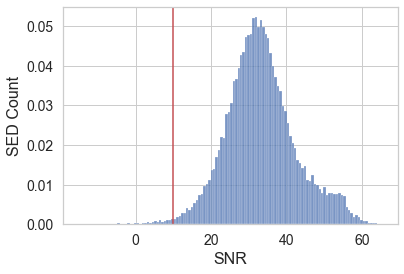

In [18]:
sns.histplot(SNR, stat='density');
plt.ylabel('SED Count')
plt.xlabel('SNR')
plt.axvline(x=10, c='r')

In [19]:
# Calculate values with SNR <10 dB
SNR_less10 = np.count_nonzero(np.where(SNR<10))
print(f'%0.2f percent of SED have a signal (at nominal frequency) of < 10dB above the average noise level at the target detpth' % (SNR_less10/len(SED_df)*100))

0.70 percent of SED have a signal (at nominal frequency) of < 10dB above the average noise level at the target detpth


NameError: name 'SED_TS' is not defined

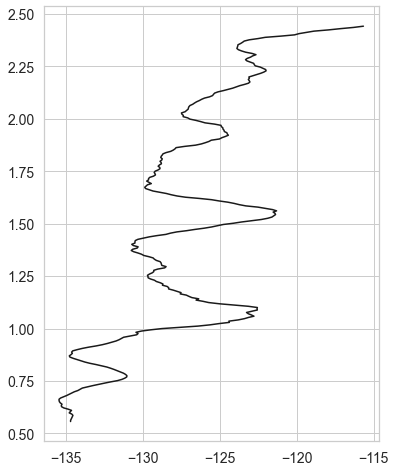

In [20]:
plt.figure(figsize=(6,8))
plt.plot(smooth_TS, depth_smooth, 'k-', label='Noise level')
for ind in range(500):
    plt.plot([np.min(SED_TS,1)[ind],np.max(SED_TS,1)[ind]],[SED[ind,2], SED[ind,2]], 'r-')
plt.axhline(1)
plt.axhline(2.25)
plt.ylim([0.5,2.5])
plt.xlabel('dB re 1m$^2$')
plt.ylabel('Range (m)')
plt.legend(fontsize=15)
plt.gca().invert_yaxis()


In [ ]:
depth_smooth